In [1]:
# ARCH and GARCH
# In the real financial data, especially the return, the change in volatility is a very special characteristics.
# Therefore, if we restrict our model to be homoskedastic, it will ignore this feature of finanical time series.
# To take this into account, we use the ARCH and GARCH models to catch the movement and behaviour of returns

# This model is the extended model of the univariate AR(2) process, in which the variance (volatility) of the error term is
# allowed to be heteroskedastic.

# Accordingly, we have:
# y(t) = a0 + a1*y(t-1) + a2*y(t-2) + u(t), where u(t) = sqrt(b0 + b1*u(t-1)^2 + ... + bq*u(t-q)^2)*w(t)
# w(t) here is the normal white noise process (E(w(t)) = 0 and E(w(t)w(s)) = 1 if t = s, and = 0 otherwise).

# In this section, we assume that the true model follows ARCH(1) process (q = 1)

# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv

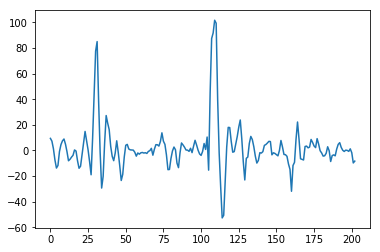

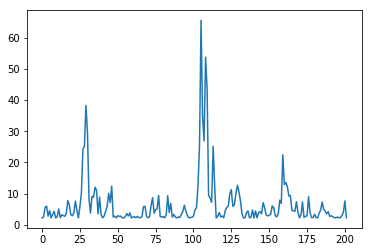

In [2]:
# Simulation, data generating process
q = 2
a0 = 0
a1 = 1
a2 = -1/2
b0 = 5
b1 = 1
T = 300
y0 = np.random.normal(0,50)
y1 = np.random.normal(0,50)
u0 = np.random.normal(0,50)
y = np.zeros((T,1), dtype = float)
u = np.zeros((T,1), dtype = float)
u[1] = u0
y[0] = y0
y[1] = y1

for i in range(2,T):
    u[i] = np.sqrt(b0 + b1*(u[i-1]**2))*np.random.normal(0,1)
    y[i] = a0 + a1*y[i-1] + a2*y[i-2] + u[i]


y = y[97:]

_ = plt.figure
_ = plt.plot(range(len(y)), y)
plt.show()

# The volatilities of error terms over time are
vol = np.sqrt(b0 + b1*(u[98:]**2))

_ = plt.figure
_ = plt.plot(range(len(vol)), vol)
plt.show()

# Now, we can easily see that the volatilities of the series change over time

In [3]:
# Now, we try to construct a function estimating this model with the Maximum Likelihood estimator

# The likelihood function
def likelihood_ARCH(x):
    L = 0
    for i in range(3,len(y)):
        ht = x[0] + x[1]*(y[i-1] - x[2] - x[3]*y[i-2] - x[4]*y[i-3])**2
        first_term = -1/2*np.log(ht)
        ut = y[i] - x[2] - x[3]*y[i-1] - x[4]*y[i-2]
        second_term = -1/2*(ut**2)/ht
        L += first_term + second_term
    return float(-1/2*L)

# Check
likelihood_ARCH([b0,b1,a0,a1,a2])

215.12422278882693

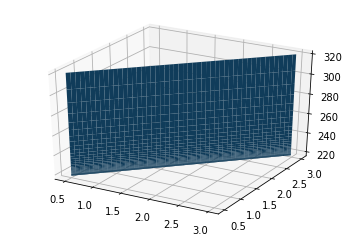

In [4]:
# Now, we try to maximize that function using some optimization tools.
# Firstly, we try to visualize the behaviour of likelihood function
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Assume a0, a1, a2 is fixed as before, we allow b0 and b1 to vary from -5 to 5
b_0 = np.arange(0.5, 3, 0.01, dtype = float)
b_1 = np.arange(0.5, 3, 0.01, dtype = float)
L = np.zeros((len(b_0),1), dtype = float)
for j in range(len(b_0)):
    L[j] = likelihood_ARCH([b_0[j], b_1[j], a0, a1, a2])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(b_0, b_1, L, linewidth=0.2)
plt.show()

In [5]:
# We will use some numerical methods in Python to estimate the model
initial_state = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
from scipy.optimize import minimize

est_NM = minimize(likelihood_ARCH, initial_state, method = 'nelder-mead', options={'xtol': 1e-8, 'disp': True})

In [6]:
print(est_NM.x)

[ 3.01136197  2.32169714 -0.31270038  0.82876175 -0.43453127]


In [7]:
# We can see that the optimization works pretty well when their estimates are quite close to the true parameters
b0_est = est_NM.x[0]
b1_est = est_NM.x[1]
a0_est = est_NM.x[2]
a1_est = est_NM.x[3]
a2_est = est_NM.x[4]
print([b0_est, b1_est, a0_est, a1_est, a2_est])

[3.011361970264608, 2.32169714133249, -0.3127003782813124, 0.8287617485824375, -0.4345312691320762]


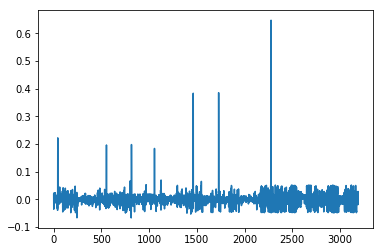

In [8]:
# Test with the real data. We will use the data of VNM stock (Vietnam diary joint stock company) to compute the return
# Data set is provided by cophieu68.vn
df = pd.read_csv('vnm.csv')
df = pd.DataFrame(df)

# We will use the closing prices to compute the return which is shown by the column 'GiaDongCua'
price = df.loc[:,'GiaDongCua']

# The log-return is
p_lag = np.log(price[:len(price)-1])
p = np.log(price[1:])
log_r = np.array(p) - np.array(p_lag)

# Visualize the data
_ = plt.figure
_ = plt.plot(range(len(log_r)), log_r)
plt.show()

In [9]:
# Now, we assume that this return follows the AR(2) process with ARCH(1) model in the error term
y = log_r

# To ensure the consistency of the optimization, I use several initial value sets
est1 = minimize(likelihood_ARCH, [0,0,0,0,0], method = 'nelder-mead', options={'xtol': 1e-8, 'disp': True})
est2 = minimize(likelihood_ARCH, [2,1,2,1,-1/2], method = 'nelder-mead', options={'xtol': 1e-8, 'disp': True})
est3 = minimize(likelihood_ARCH, [4,1.5,0,-2,1.5], method = 'nelder-mead', options={'xtol': 1e-8, 'disp': True})

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Optimization terminated successfully.
         Current function value: -5226.514559
         Iterations: 585
         Function evaluations: 999
Optimization terminated successfully.
         Current function value: -5215.680810
         Iterations: 558
         Function evaluations: 973


In [10]:
print(est1.x)
print(est2.x)
print(est3.x)

# Compute the corresponding likelihood
L1 = likelihood_ARCH(est1.x)
L2 = likelihood_ARCH(est2.x)
L3 = likelihood_ARCH(est3.x)

# Print them
print([L1, L2, L3])

[ 2.67555092e-04  1.11063443e+00 -1.58044789e-03 -5.35135754e-02
  2.13186628e-03]
[ 1.73152120e-04  2.63974727e+00 -2.18168797e-03 -1.35357287e-01
 -2.94600957e-02]
[ 1.69819451e-04  2.79148613e+00 -2.26088649e-03 -1.62705782e-01
  3.33821959e-02]
[-5259.576941164839, -5226.514559253367, -5215.680810344001]


In [ ]:
# We can see that the value are pretty much similar, showing that the optimization is stable.
# The second estimate ends up with the successful convergence and highest likelihood, then we will choose it as our final estimate